In [1]:
%cd ..

/data/sunjinsheng/codebase/var_mar


In [4]:
from pathlib import Path

from PIL import Image
import torch 
import torchvision.transforms as tf
from einops import rearrange

In [3]:
from models.mae import mae_vit_base_patch16
model = mae_vit_base_patch16()

In [5]:
path_image = 'data/RealHM/vendor_testing_2/pexels-craig-adderley-1563356_fore.jpg'

In [6]:
transfroms = tf.Compose([
    tf.Resize((224,224)),
    tf.ToTensor()
])
transfroms_gray = tf.Compose([
    tf.Grayscale(),
    tf.Resize((224, 224)),
    tf.ToTensor()
])

In [7]:
image = Image.open(path_image).convert('RGB')
tensor_image = transfroms(image)
tensor_image = tensor_image.unsqueeze(0)
tensor_gray = transfroms_gray(image)
tensor_gray = tensor_gray.unsqueeze(0)
tensor_gray = tensor_gray.expand(-1, 3, -1, -1)
tensor_image.shape, tensor_gray.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [8]:
def tensor_2_image(x:torch.Tensor) -> Image:
    # x.shape: n c h w
    assert 4 == x.dim() 
    x = rearrange(x, 'n c h w -> c h (w n)')
    # (255*x.clip(0,1)).to(torch.uint8).cpu().numpy()
    return tf.functional.to_pil_image(x)
def tensor_2_patch_image(x:torch.Tensor, patch_size:int=16) -> Image:
    p = q = patch_size
    x = rearrange(x, 'n c (h p) (w q) -> n c (h w) p q', p = p, q = q)
    x = torch.nn.functional.pad(x, (2,2), mode='constant', value=1.0)
    x = rearrange(x, 'n c L p q -> n c (p q)  L')
    noise = torch.rand(x.shape[-1])
    ids_random = torch.argsort(noise)
    ids_random = ids_random.expand(1,3,3360,-1)
    x = torch.gather(x, dim = 3, index=ids_random)
    x = rearrange(x, ' n c (p q) (h w) -> c (n p) (h w q)', p = 56, h = 4, )
    return tf.functional.to_pil_image(x)

In [9]:
x = tensor_image.clone()
patch_size = 56

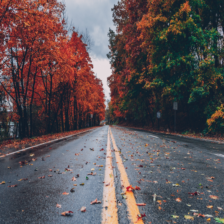

In [10]:
tensor_2_image(tensor_image)

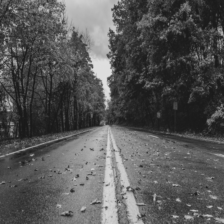

In [11]:
tensor_2_image(tensor_gray)

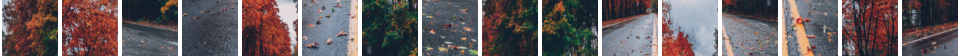

In [12]:
tensor_2_patch_image(tensor_image, patch_size=56)

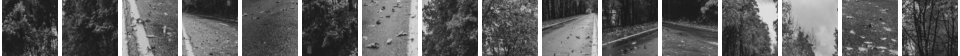

In [13]:
tensor_2_patch_image(tensor_gray, patch_size=56)

In [14]:
x = tensor_image.detach().clone()
g = tensor_gray.detach().clone()

In [39]:
x_patched = model.patchify(x)
g_patched = model.patchify(g)
mask_ratio = 0.4

In [40]:
x_patched.shape  #x: (N, L=h_*w_, patch_size**2*channel)
# patch_size : p = q = 16 
# h_ = h // p : 224 // 16 = 14
# w_ = w // q : 224 // 16 = 14 
# channel_size : c = 3
# >>
# N = 1
# L = h_ * w_ = 14 * 14 = 196  
# D = p * q * c = 16 * 16 * 3 = 768

torch.Size([1, 196, 768])

In [41]:
x_hat = model.unpatchify(x_patched)

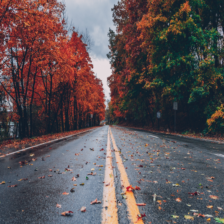

In [42]:
tensor_2_image(x_hat)

## random graying

In [43]:
# def random_masking(x, mask_ratio):
"""
Perform per-sample random masking by per-sample shuffling.
Per-sample shuffling is done by argsort random noise.
x: [N, L, D], sequence
"""
N, L, D = x_patched.shape  # batch, length, dim
len_keep = int(L * (1 - mask_ratio))

In [44]:
noise = torch.rand(N, L, device=x_patched.device)  # noise in [0, 1]
noise.shape

torch.Size([1, 196])

In [45]:
# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)
# keep the first subset
ids_keep = ids_shuffle[:, :len_keep]
ids_gray = ids_shuffle[:, len_keep:]
x_masked = torch.gather(x_patched, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
g_masked = torch.gather(g_patched, dim=1, index=ids_gray.unsqueeze(-1).repeat(1, 1, D))
x_masked.shape, g_masked.shape

(torch.Size([1, 117, 768]), torch.Size([1, 79, 768]))

In [46]:
# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L], device=x_patched.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)

# return x_masked, mask, ids_restore

## drop masking
x_mask, mask, ids_store -> x

In [47]:
x_ = torch.cat([x_masked, g_masked], dim=1)  # no cls token
x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_masked.shape[2]))  # unshuffle
x_ = model.unpatchify(x_)

In [48]:
x_.shape

torch.Size([1, 3, 224, 224])

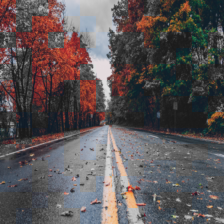

In [49]:
tensor_2_image(x_)